<a href="https://colab.research.google.com/github/RagaaM/Scriba/blob/main/EffNet_Without_Aug_Franken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# m --> my comment
# change CPU to GPU
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install torchsummary
!pip install efficientnet_pytorch
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from sklearn import metrics
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import os
import torchvision
import shutil
from torch.autograd import Variable
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
from torchsummary import summary
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
from tqdm.autonotebook import tqdm    # Progress bar --> FunFact: comes from arabic word تقدم :) 

In [3]:
#parameters
batch_size = 50
im_size = 150
# Train and Test files
train_set = '/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/train'
test_set = '/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test'
print(test_set)

/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test


In [4]:
def normalization_parameter(dataloader):
    mean = 0.
    std = 0.
    nb_samples = len(dataloader.dataset)
    for data,_ in tqdm(dataloader):
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
    mean /= nb_samples
    std /= nb_samples
    return mean.numpy(),std.numpy()

im_size = 150
train_transforms = transforms.Compose([
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor()])
train_data = torchvision.datasets.ImageFolder(root = train_set , transform = train_transforms)
train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)

mean,std = normalization_parameter(train_loader)

  0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
# Data Augmentation in train and test 
# train_transforms = transforms.Compose([
#                                         transforms.Resize((im_size,im_size)),
#                                         transforms.RandomResizedCrop(size=315, scale=(0.95, 1.0)),
#                                         transforms.RandomRotation(degrees=10),
#                                         transforms.RandomHorizontalFlip(),
#                                         transforms.CenterCrop(size=299),  # Image net standards
#                                         transforms.ToTensor(),
#                                         transforms.Normalize(mean,std)])
# test_transforms = transforms.Compose([
#                                         transforms.Resize((im_size,im_size)),
#                                         transforms.ToTensor(),
#                                         transforms.Normalize(mean,std)])

#inverse normalization for image plot
inv_normalize =  transforms.Normalize(
    mean=-1*np.divide(mean,std),
    std=1/std
)

# Without Data Augmentation
train_transforms  = transforms.Compose([
    transforms.ToTensor()])

test_transforms  = transforms.Compose([
    transforms.ToTensor()])

In [6]:
#splitting files stage
def data_loader(train_data,test_data = None , valid_size = None , batch_size = 32):
    train_loader =  DataLoader(train_data, batch_size = batch_size , shuffle = True)
    if(test_data == None and valid_size == None):
        dataloaders = {'train':train_loader}
        return dataloaders
    if(test_data == None and valid_size!=None):
        data_len = len(train_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        valid_loader = DataLoader(train_data, batch_size= batch_size, sampler=valid_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader}
        return dataloaders
    if(test_data != None and valid_size!=None):
        data_len = len(test_data)
        indices = list(range(data_len))
        np.random.shuffle(indices)
        split1 = int(np.floor(valid_size * data_len))
        valid_idx , test_idx = indices[:split1], indices[split1:]
        valid_sampler = SubsetRandomSampler(valid_idx)
        test_sampler = SubsetRandomSampler(test_idx)
        valid_loader = DataLoader(test_data, batch_size= batch_size, sampler=valid_sampler)
        test_loader = DataLoader(test_data, batch_size= batch_size, sampler=test_sampler)
        dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
        return dataloaders

In [7]:
#data loader
train_data = torchvision.datasets.ImageFolder(root = train_set, transform = train_transforms)  #uncommented
test_data = torchvision.datasets.ImageFolder(root = test_set, transform = test_transforms)
dataloaders = data_loader(train_data,test_data , valid_size = 0.2 , batch_size = batch_size)
#label of classes
classes = train_data.classes
# print(classes)
#encoder and decoder to convert classes into integer
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]
# print(dataloaders.keys())

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


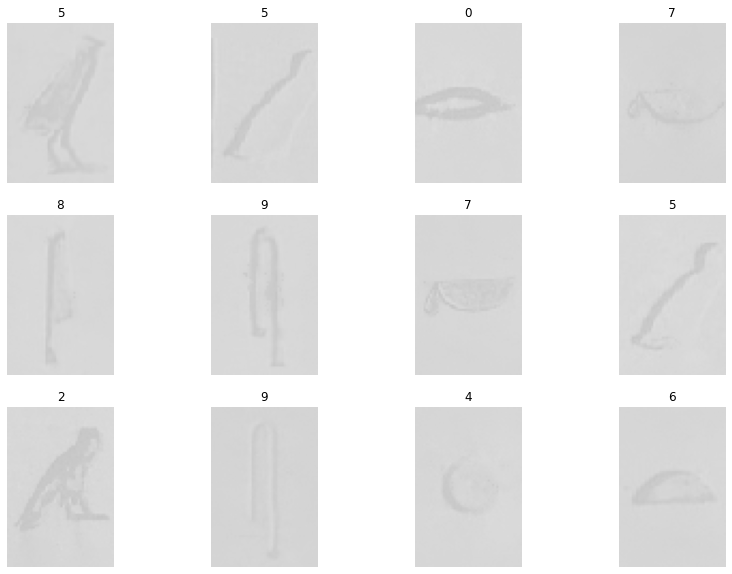

In [8]:
import matplotlib.pyplot as plt
import random
#plotting rondom images from dataset
# Images without data augmnetation
def class_plot(data , encoder ,inv_normalize = None,n_figures = 12):
    n_row = int(n_figures/4)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=4)
    for ax in axes.flatten():
        a = random.randint(0,len(data))
        (image,label) = data[a]
        print(type(image))
        label = int(label)
        l = encoder[label]
        if(inv_normalize!=None):
            image = inv_normalize(image)
        
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(l)
        ax.axis('off')
    plt.show()
class_plot(train_data,encoder,inv_normalize)

In [9]:
#using efficientnet model based transfer learning
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.resnet =  EfficientNet.from_pretrained('efficientnet-b0')
        self.l1 = nn.Linear(1000 , 256)
        self.dropout = nn.Dropout(0.75)
        self.l2 = nn.Linear(256,11)    #modify 6 --> 10  (in pytorch it has to be numofclasses+1 (stackoverflow answer)) (num of classes)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.resnet(input)
        x = x.view(x.size(0),-1)
        x = self.dropout(self.relu(self.l1(x)))
        x = self.l2(x)
        return x

torch.cuda.empty_cache()   # just when use GPU to pervent any GPUs errors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
classifier = Classifier().to(device)

cpu
Loaded pretrained weights for efficientnet-b0


In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
import numpy as np
import torch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), '/content/drive/MyDrive/SCRIBA/Model-EffNet/effnet.pt')
        self.val_loss_min = val_loss

In [12]:
def train(model,dataloaders,criterion,num_epochs=10,lr=0.00001,batch_size=8,patience = None):
    since = time.time()
    model.to(device)
    best_acc = 0.0
    i = 0
    phase1 = dataloaders.keys()
    losses = list()
    acc = list()
    if(patience!=None):
        earlystop = EarlyStopping(patience = patience,verbose = True)   # if loss improved
    for epoch in range(num_epochs):
        print('Epoch:',epoch)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        lr = lr*0.8
        if(epoch%10==0):
            lr = 0.0001

        for phase in phase1:
            if phase == ' train':
                model.train()
            else:    # test and val
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            total = 0
            j = 0
            for  batch_idx, (data, target) in enumerate(dataloaders[phase]):
                data, target = Variable(data), Variable(target)
                data = data.type(torch.FloatTensor)   # use cpu instead of gpu
                target = target.type(torch.LongTensor)
                optimizer.zero_grad()  #This will in general have lower memory footprint, and can modestly improve performance instead of giving zero value.
                output = model(data)
                # print(output.shape)   # el mafrod yetla3 [batch_size,num_of_classes]   --> tale3ly [100,6]   6 el mafrod tkon 10
                loss = criterion(output, target)  # hn-check hena
                _, preds = torch.max(output, 1)
                running_corrects = running_corrects + torch.sum(preds == target.data)
                running_loss += loss.item() * data.size(0)
                j = j+1
                if(phase =='train'):
                    loss.backward()
                    optimizer.step()

                if batch_idx % 300 == 0:
                    print('{} Epoch: {}  [{}/{} ({:.0f}%)]\tLoss: {:.6f} \tAcc: {:.6f}'.format(phase,epoch, batch_idx * len(data), len(dataloaders[phase].dataset),100. * batch_idx / len(dataloaders[phase])
                                                                                                 , running_loss/(j*batch_size),running_corrects.double()/(j*batch_size)))
            epoch_acc = running_corrects.double()/(len(dataloaders[phase])*batch_size)
            epoch_loss = running_loss/(len(dataloaders[phase])*batch_size)
            if(phase == 'val'):
                earlystop(epoch_loss,model)

            if(phase == 'train'):
                losses.append(epoch_loss)
                acc.append(epoch_acc)
            print(earlystop.early_stop)
        if(earlystop.early_stop):
            print("Early stopping")
            model.load_state_dict(torch.load('/content/drive/MyDrive/SCRIBA/Model-EffNet/effnet.pt'))
            break
        print('{} Accuracy: '.format(phase),epoch_acc.item())
    return losses,acc

In [13]:
def test(dataloader):
    running_corrects = 0
    running_loss=0
    pred = []
    true = []
    pred_wrong = []
    true_wrong = []
    image = []
    sm = nn.Softmax(dim = 1)
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = Variable(data), Variable(target)
        data = data.type(torch.FloatTensor)   # change torch.cuda.FloatTensor --> torch.FloatTensor
        target = target.type(torch.LongTensor)   # change torch.cuda.LongTensor --> torch,LongTensor   (CPU instead of GPU)
        classifier.eval()
        output = classifier(data)
        loss = criterion(output, target)
        output = sm(output)
        _, preds = torch.max(output, 1)
        running_corrects = running_corrects + torch.sum(preds == target.data)
        running_loss += loss.item() * data.size(0)
        preds = preds.cpu().numpy()
        target = target.cpu().numpy()
        preds = np.reshape(preds,(len(preds),1))
        target = np.reshape(target,(len(preds),1))
        data = data.cpu().numpy()
        
        for i in range(len(preds)):
            pred.append(preds[i])
            true.append(target[i])
            if(preds[i]!=target[i]):
                pred_wrong.append(preds[i])
                true_wrong.append(target[i])
                image.append(data[i])
      
    epoch_acc = running_corrects.double()/(len(dataloader)*batch_size)
    epoch_loss = running_loss/(len(dataloader)*batch_size)
    print(epoch_acc,epoch_loss)
    return true,pred,image,true_wrong,pred_wrong

In [14]:
def error_plot(loss):
    plt.figure(figsize=(10,5))
    plt.plot(loss)
    plt.title("Training loss plot")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.show()
def acc_plot(acc):
    plt.figure(figsize=(10,5))
    plt.plot(acc)
    plt.title("Training accuracy plot")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

# To plot the wrong predictions given by model
def wrong_plot(n_figures,true,ima,pred,encoder,inv_normalize):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/3)
    fig,axes = plt.subplots(figsize=(14, 10), nrows = n_row, ncols=3)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+c + ',' +'P:'+w
        if inv_normalize !=None:
            image = inv_normalize(image)
        image = image.numpy().transpose(1,2,0)
        im = ax.imshow(image)
        ax.set_title(f)
        ax.axis('off')
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
def performance_matrix(true,pred):
    precision = metrics.precision_score(true,pred,average='macro')
    recall = metrics.recall_score(true,pred,average='macro')
    accuracy = metrics.accuracy_score(true,pred)
    f1_score = metrics.f1_score(true,pred,average='macro')
    print('Precision: {} Recall: {}, Accuracy: {}: ,f1_score: {}'.format(precision*100,recall*100,accuracy*100,f1_score*100))

In [15]:
def train_model(model,dataloaders,criterion,num_epochs,lr=0.0001,batch_size=8,patience = None,classes = None):
    dataloader_train = {}
    losses = list()
    accuracy = list()
    key = dataloaders.keys()
    for phase in key:
        if(phase == 'test'):
            perform_test = True
        else:
            dataloader_train.update([(phase,dataloaders[phase])])
    losses,accuracy = train(model,dataloader_train,criterion,num_epochs,lr,batch_size,patience)
    error_plot(losses)
    acc_plot(accuracy)
    if(perform_test == True):
        true,pred,image,true_wrong,pred_wrong = test(dataloaders['test'])
        wrong_plot(12,true_wrong,image,pred_wrong,encoder,inv_normalize)
        performance_matrix(true,pred)
        if(classes !=None):
            plot_confusion_matrix(true, pred, classes= classes,title='Confusion matrix, without normalization')

Epoch: 0
train Epoch: 0  [0/1453 (0%)]	Loss: 2.383063 	Acc: 0.140000
False
val Epoch: 0  [0/198 (0%)]	Loss: 0.165290 	Acc: 0.760000
Validation loss decreased (inf --> 0.165290).  Saving model ...
False
val Accuracy:  0.76
Epoch: 1
train Epoch: 1  [0/1453 (0%)]	Loss: 0.145374 	Acc: 0.960000
False
val Epoch: 1  [0/198 (0%)]	Loss: 0.165274 	Acc: 0.760000
Validation loss decreased (0.165290 --> 0.165274).  Saving model ...
False
val Accuracy:  0.76
Epoch: 2
train Epoch: 2  [0/1453 (0%)]	Loss: 0.046599 	Acc: 0.980000
False
val Epoch: 2  [0/198 (0%)]	Loss: 0.163042 	Acc: 0.760000
Validation loss decreased (0.165274 --> 0.163042).  Saving model ...
False
val Accuracy:  0.76
Epoch: 3
train Epoch: 3  [0/1453 (0%)]	Loss: 0.105395 	Acc: 0.960000
False
val Epoch: 3  [0/198 (0%)]	Loss: 0.151488 	Acc: 0.760000
Validation loss decreased (0.163042 --> 0.151488).  Saving model ...
False
val Accuracy:  0.76
Epoch: 4
train Epoch: 4  [0/1453 (0%)]	Loss: 0.012849 	Acc: 1.000000
False
val Epoch: 4  [0/198 (

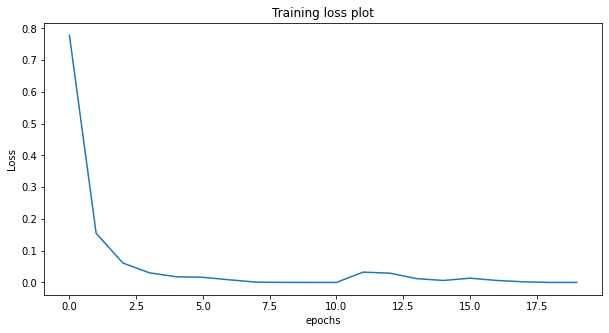

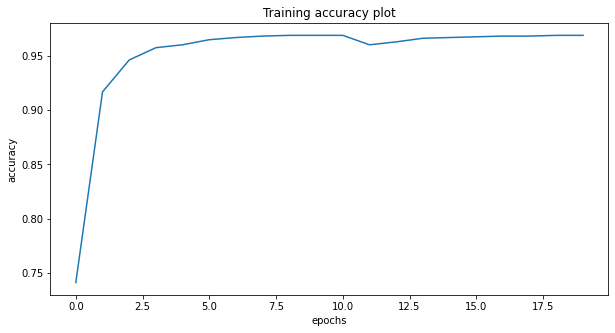

tensor(0.7850, dtype=torch.float64) 0.15853985068271684
Classes in order Actual and Predicted


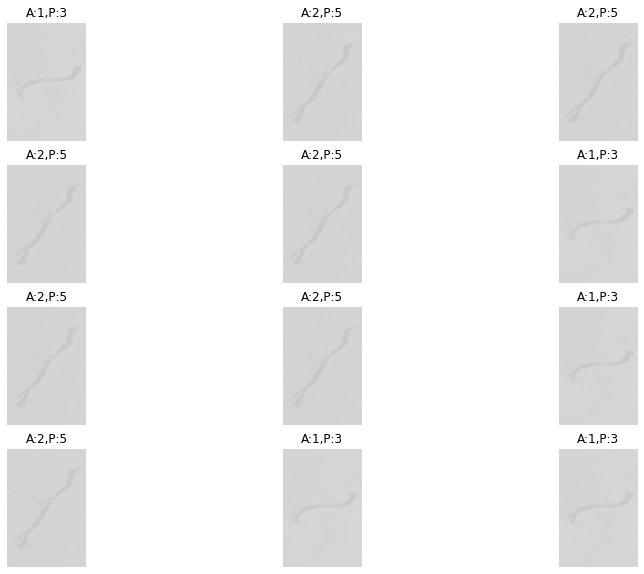

Precision: 98.74509803921569 Recall: 98.78676470588236, Accuracy: 98.74213836477988: ,f1_score: 98.7265311625712
Confusion matrix, without normalization
[[17  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  1  0  0  0  0  0  0]
 [ 0  0 15  0  0  1  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  0  0 15  0]
 [ 0  0  0  0  0  0  0  0  0 13]]


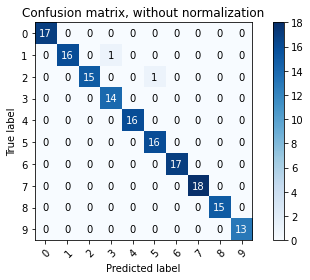

In [16]:
train_model(classifier,dataloaders,criterion,20, patience = 19 , batch_size = batch_size , classes = classes)

In [17]:
from PIL import Image
import numpy as np
import cv2

def predict(model,image,device,encoder,transforms = None,inv_normalize = None):
    #model = torch.load('./model.h5')
    model.eval()
    if(isinstance(image,np.ndarray)):
      image = Image.fromarray(image)
    if(transforms!=None):
        image = transforms(image)
    data = image.expand(1,-1,-1,-1)
    data = data.type(torch.FloatTensor).to(device)
    sm = nn.Softmax(dim = 1)
    output = model(data)
    output = sm(output)
    _, preds = torch.max(output, 1)
    img_plot(image,inv_normalize)
    prediction_bar(output,encoder)
    return preds
def prediction_bar(output,encoder):
    output = output.cpu().detach().numpy()
    a = output.argsort()
    print(a)
    a = a[0]
    print(a)
    
    size = len(a)
    if(size>5):
        a = np.flip(a[-5:])
    else:
        a = np.flip(a[-1*size:])
    prediction = list()
    clas = list()
    for i in a:
      prediction.append(float(output[:,i]*100))
      clas.append(str(i))
    for i in a:
        print('Class: {} , confidence: {}'.format(encoder[int(i)],float(output[:,i]*100)))
    plt.bar(clas,prediction)
    plt.title("Confidence score bar graph")
    plt.xlabel("Confidence score")
    plt.ylabel("Class number")
 
def img_plot(image,inv_normalize = None):
    if(inv_normalize!=None):
        image = inv_normalize(image)
    image = image.cpu().numpy().transpose(1,2,0)
    plt.imshow(image)
    plt.show()

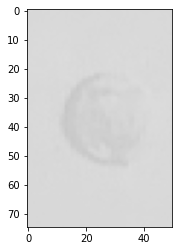

[[10  5  3  1  0  9  7  2  6  8  4]]
[10  5  3  1  0  9  7  2  6  8  4]
Class: 4 , confidence: 100.0
Class: 8 , confidence: 3.090582367804018e-08
Class: 6 , confidence: 7.860885276045337e-09
Class: 2 , confidence: 3.798681369460155e-09
Class: 7 , confidence: 2.9894717812339877e-09


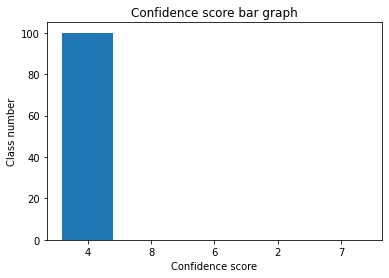

In [21]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test/4/070451_O50.png')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

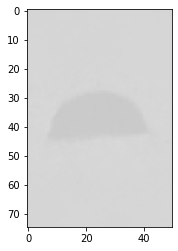

[[10  5  3  4  0  9  7  1  8  2  6]]
[10  5  3  4  0  9  7  1  8  2  6]
Class: 6 , confidence: 100.0
Class: 2 , confidence: 4.3988155340457524e-08
Class: 8 , confidence: 1.5191725211138873e-08
Class: 1 , confidence: 6.3896603563762255e-09
Class: 7 , confidence: 1.9714254673175446e-09


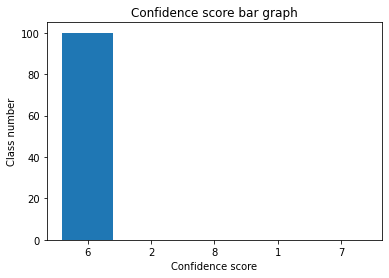

In [22]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test/6/030270_X1.png')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

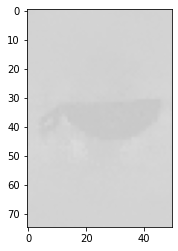

[[10  9  3  6  0  2  4  5  8  1  7]]
[10  9  3  6  0  2  4  5  8  1  7]
Class: 7 , confidence: 99.99998474121094
Class: 1 , confidence: 5.430242708825972e-06
Class: 8 , confidence: 4.819736204808578e-06
Class: 5 , confidence: 1.0959431619994575e-06
Class: 4 , confidence: 9.459245831067165e-08


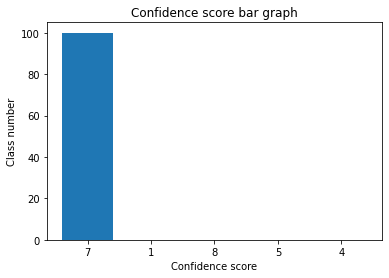

In [23]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test/7/050342_V31.png')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

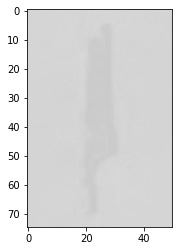

[[10  0  3  1  4  7  9  6  5  2  8]]
[10  0  3  1  4  7  9  6  5  2  8]
Class: 8 , confidence: 100.0
Class: 2 , confidence: 1.197383997508794e-10
Class: 5 , confidence: 9.404987205696713e-12
Class: 6 , confidence: 7.496631895982653e-13
Class: 9 , confidence: 4.57580174651525e-14


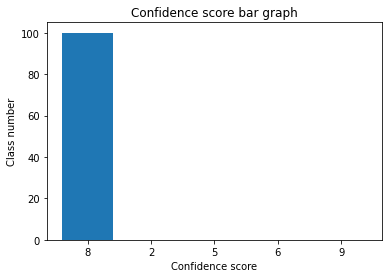

In [24]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test/8/030244_M17.png')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

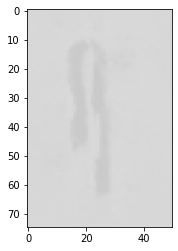

[[ 5  7 10  4  0  3  6  1  2  8  9]]
[ 5  7 10  4  0  3  6  1  2  8  9]
Class: 9 , confidence: 100.0
Class: 8 , confidence: 1.97226519560445e-08
Class: 2 , confidence: 1.825675965960727e-08
Class: 1 , confidence: 1.3398265608088877e-08
Class: 6 , confidence: 1.5520154050818746e-09


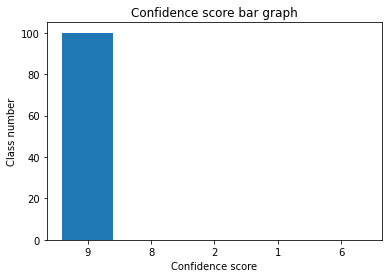

In [25]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test/9/030179_S29.png')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

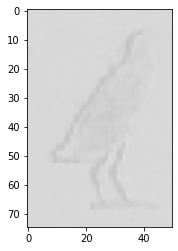

[[10  9  0  4  8  3  2  1  7  6  5]]
[10  9  0  4  8  3  2  1  7  6  5]
Class: 5 , confidence: 100.0
Class: 6 , confidence: 1.5485386410662993e-12
Class: 7 , confidence: 1.5314933566115685e-12
Class: 1 , confidence: 4.1987214486477464e-13
Class: 2 , confidence: 2.246589721167317e-14


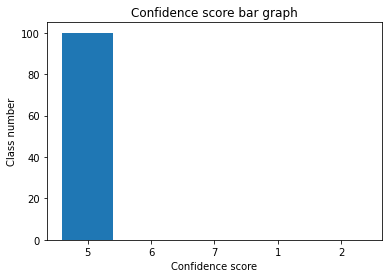

In [26]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test/5/070225_G43.png')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

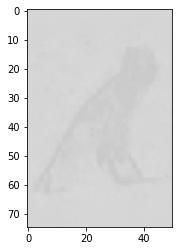

[[ 0 10  9  4  3  1  8  6  7  5  2]]
[ 0 10  9  4  3  1  8  6  7  5  2]
Class: 2 , confidence: 100.0
Class: 5 , confidence: 2.3900930123943454e-09
Class: 7 , confidence: 2.0032328226782248e-11
Class: 6 , confidence: 3.2561585806140103e-12
Class: 8 , confidence: 2.7145619736421156e-13


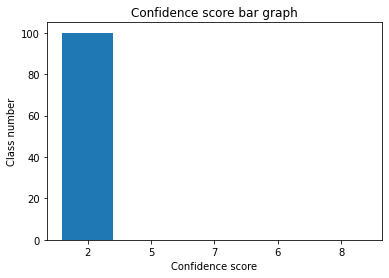

In [27]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/Dataset-Ragaa/data/test/2/090203_G17.png')
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

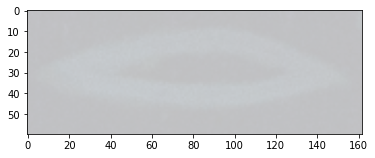

[[10  2  5  8  3  9  1  7  6  4  0]]
[10  2  5  8  3  9  1  7  6  4  0]
Class: 0 , confidence: 98.7939224243164
Class: 4 , confidence: 0.9522693157196045
Class: 6 , confidence: 0.08865568041801453
Class: 7 , confidence: 0.037331365048885345
Class: 1 , confidence: 0.03598365560173988


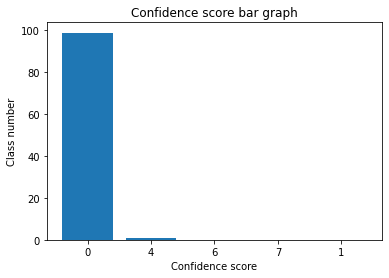

In [28]:
#OUR DATASET IMAGE SAMPLE 
image = cv2.imread('/content/drive/MyDrive/SCRIBA/dataset-manual-test/test/D21/D21-11.PNG')    #class 0
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

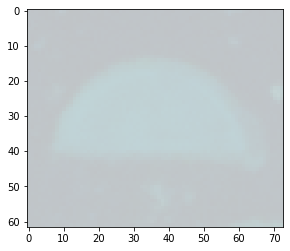

[[10  9  3  5  4  1  0  7  2  8  6]]
[10  9  3  5  4  1  0  7  2  8  6]
Class: 6 , confidence: 96.6550521850586
Class: 8 , confidence: 3.2608792781829834
Class: 2 , confidence: 0.06472492963075638
Class: 7 , confidence: 0.01106770895421505
Class: 0 , confidence: 0.0032727038487792015


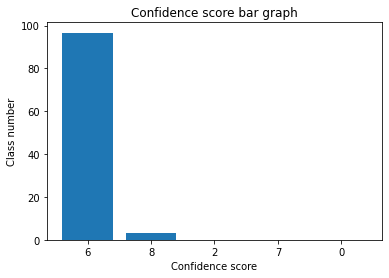

In [32]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/dataset-manual-test/test/X1/X1-2.PNG')     #class 6 
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

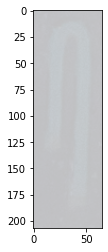

[[ 5 10  3  7  0  2  6  4  1  8  9]]
[ 5 10  3  7  0  2  6  4  1  8  9]
Class: 9 , confidence: 67.54851531982422
Class: 8 , confidence: 31.079938888549805
Class: 1 , confidence: 0.6185000538825989
Class: 4 , confidence: 0.26336950063705444
Class: 6 , confidence: 0.17803502082824707


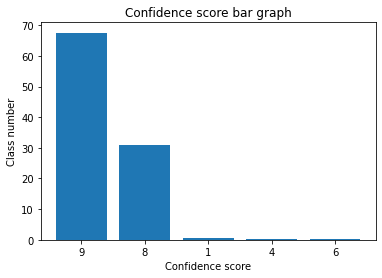

In [37]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/dataset-manual-test/test/S29/S29-5.PNG')   #class 9
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

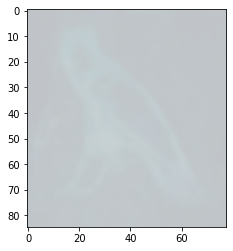

[[10  0  9  3  1  4  8  5  7  6  2]]
[10  0  9  3  1  4  8  5  7  6  2]
Class: 2 , confidence: 83.58403778076172
Class: 6 , confidence: 7.977310657501221
Class: 7 , confidence: 3.5001680850982666
Class: 5 , confidence: 1.7566142082214355
Class: 8 , confidence: 1.6428728103637695


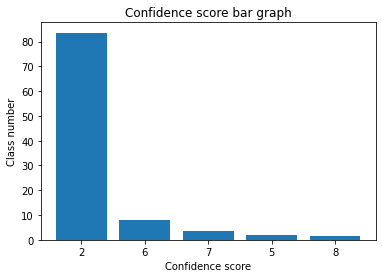

In [42]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/dataset-manual-test/test/G17/G17-4.PNG')    #class 2
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)

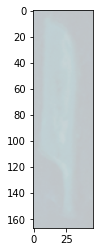

[[10  0  3  7  1  4  9  5  2  6  8]]
[10  0  3  7  1  4  9  5  2  6  8]
Class: 8 , confidence: 100.0
Class: 6 , confidence: 4.019796506327111e-06
Class: 2 , confidence: 3.791484914472676e-06
Class: 5 , confidence: 8.880078894435428e-07
Class: 9 , confidence: 5.056658096691535e-07


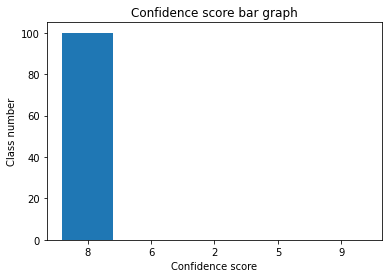

In [43]:
image = cv2.imread('/content/drive/MyDrive/SCRIBA/dataset-manual-test/test/M17/M17-0.PNG')    #class 8
pred = predict(classifier,image,device,encoder,test_transforms,inv_normalize)